# Import libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image
import time

In [2]:
import torch
import torchvision
from torch import optim
from torchvision import transforms
from torchvision.transforms import ToTensor

# **Loading the CIFAR-10 Dataset**

In [3]:
# Download the dataset and store it locally. 
train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
print(train_data)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train


In [4]:
# In this dataset, we have 10 unique items
classes = train_data.classes

print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Image data is stored inside train_data.data

In [5]:
print(type(train_data))
print()
print("Shape of the train_data.data:", train_data.data.shape)
print(type(train_data.data), " Number of data:",len(train_data.data))
print()
print(train_data[0], "--",type(train_data[0]), "Length:",len(train_data[0]), "--")
print(type(train_data[0][0]), type(train_data[0][1]))

<class 'torchvision.datasets.cifar.CIFAR10'>

Shape of the train_data.data: (50000, 32, 32, 3)
<class 'numpy.ndarray'>  Number of data: 50000

(<PIL.Image.Image image mode=RGB size=32x32 at 0x15460B1F0>, 6) -- <class 'tuple'> Length: 2 --
<class 'PIL.Image.Image'> <class 'int'>


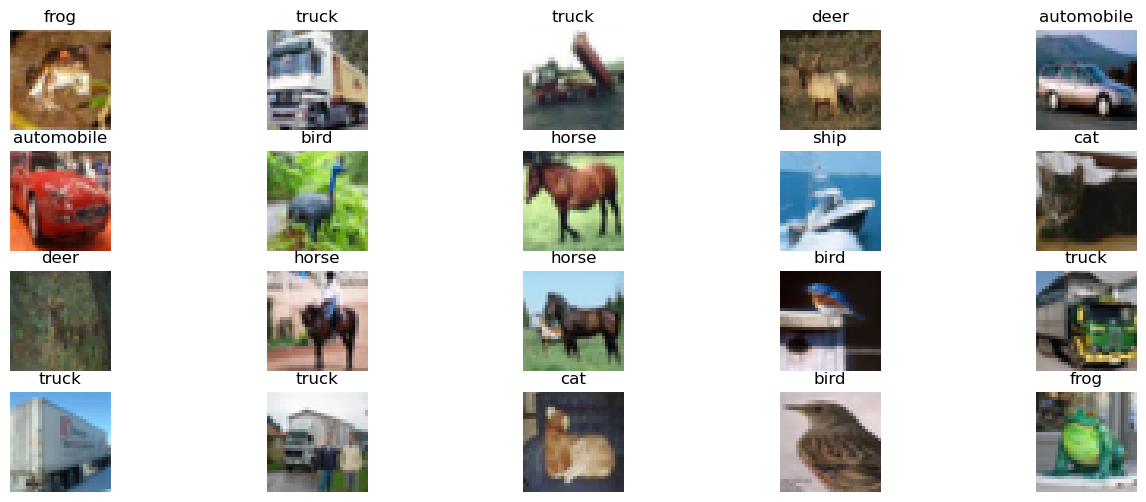

In [6]:
plt.figure(figsize = (16,6))
imgs_per_row = 5
total_imgs = 20
for i in range(total_imgs):
    #          (rows, cols, the nth plot)
    plt.subplot(math.ceil(total_imgs/imgs_per_row), imgs_per_row, 1 + i)
    plt.axis("off")
    plt.title(train_data.classes[train_data[i][1]])
    plt.imshow(train_data[i][0])

## Applying Transformation
Every thing in deep learning is in the form of Tensors. We normally apply normalization on these images, so that all the tensors are inthe same range of [-1, 1]. We will be using methods provided by torchvision.transform to approach this. 
#### Documentations: 
#### <a>https://pytorch.org/vision/0.11/transforms.html<a> | <a>https://pytorch.org/vision/stable/transforms.html<a>

<class 'torchvision.transforms.transforms.Compose'>


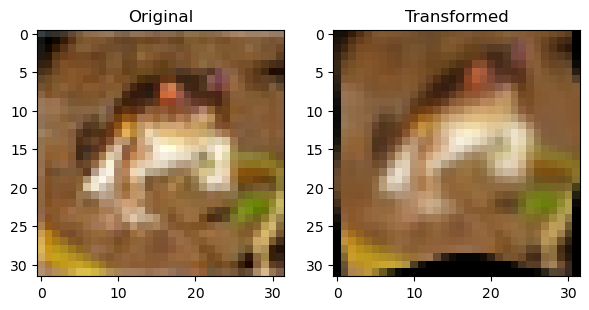

In [7]:
# Testing out the transforms.compose function
img = train_data[0][0]

trans = transforms.Compose([        
        transforms.GaussianBlur((5, 5)),
        transforms.ElasticTransform(),
        transforms.RandomErasing()
])

print(type(trans))

# Apply this transformation to the image.
img_t = trans(img)

# Display images
plt.figure(figsize = (7, 7))
plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Transformed")
plt.imshow(img_t)

# **Batching the data and Shuffling**
AI models are trained in batches, therefore the "Stochastic" in the SGD term. We can certainly batch the images manually, keep track of which label goes where and then wrap an iterator around it to return a single batch of images when iterated on. However, it requires a lot of works and we can simply use DataLoader class to do some of this heavy lifting.

In [8]:
from torch.utils.data import DataLoader
import multiprocess
import psutil

In [9]:
# Let's figure out how many cores we have. I am running a 1st gen Mac M1 Pro.
print(multiprocess.cpu_count())

10


**DataLoader needs the dataset to be in Tensors** and hence we must first transform it into that.

In [10]:
convert = transforms.Compose([
        transforms.ToTensor(), # converting the data to Tesnor for dataloader
        transforms.transforms.GaussianBlur((5, 5)),
        transforms.ElasticTransform(),
        transforms.RandomErasing()
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                          transform=convert)

Files already downloaded and verified


### As not all CPU on the M1 chip are performance cores, with some being energy or low power cores, we can go with 4 cores as the number of workers.

In [11]:
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True, num_workers = 4)

print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### In Deep Learning, batch size refers to the number of samples (examples) processed together in a single iteration during training or inference (prediction). Instead of processing the entire dataset at once, the data is divided into smaller batches, and model operates on these batches iteratively.

In [12]:
batch_images, batch_labels = next(iter(train_loader))  # Get a batch.

print(batch_images.shape)
print([classes[l] for l in batch_labels])

torch.Size([10, 3, 32, 32])
['deer', 'automobile', 'frog', 'automobile', 'deer', 'ship', 'airplane', 'automobile', 'cat', 'truck']


In [13]:
# torch.Size([10(Batch size), 3(Channels), 32(Width), 32(Height)]) ---> 4 Dimension
# Batch size: 10 images are processed together in a single batch.

batch_images[0].shape

torch.Size([3, 32, 32])

**Note** - That when PIL images are converted to tensors using ToTensor() their representation is changed from (batchSize, h, w, channels) to (batchSize, channels, w, h). This is also how all Pytorch tensor related methods expect the iamge to be.

In [14]:
print(batch_images.shape, type(batch_images))

drawable = batch_images.permute(0, 2, 3, 1)  # Permuting the order so we can easily draw it out.
print(drawable.shape, type(drawable))

torch.Size([10, 3, 32, 32]) <class 'torch.Tensor'>
torch.Size([10, 32, 32, 3]) <class 'torch.Tensor'>


In [15]:
print(type(drawable[0]))

<class 'torch.Tensor'>


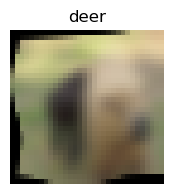

In [16]:
plt.figure(figsize=(2, 2))
plt.title(classes[batch_labels[0]])
plt.axis('off')
# valid image label don't take the batch size ---> Valid: (W, H, C)
plt.imshow(drawable[0])

# CNN Architecture 

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [39]:
class CNNs(nn.Module):
    def __init__(self):
        super(CNNs, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5)
        self.relu1 = nn.ReLU()
        self.maxPool1 = nn.MaxPool2d(2,2) #shrink the size by 2 

        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
        self.relu2 = nn.ReLU()
        self.maxPool2 = nn.MaxPool2d(2,2) #shrink the size by 2 

        # Fully connected layer
        self.ft = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    # progresses data across layers  
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxPool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxPool2(x)

        # x = x.view(-1, 16 * 6 * 6) # Flatten out the image.
        x = self.ft(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


class MyModelSimple(nn.Module):
    """
    Let's have some fun defining some simple CNN models.
    """
    def __init__(self):
        super(MyModelSimple, self).__init__()
        # Define all the layers we will use here.
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.maxpool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        """
        Forward pass
        """
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Flatten out the image.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Convert the output of the final layer into probabilitues for each class.
        
        return x  # Don't forget this, otherwise the model will return a None during prediction
        

In [43]:
# print out the size for each layer (channles, width, height)

img_rand = torch.rand(3,32,32)
print(img_rand.shape)

conv1 = nn.Conv2d(3, 6, 5)
img_rand = conv1(img_rand)
print(img_rand.shape)
mp = nn.MaxPool2d(2, 2)
img_rand = mp(img_rand)
print(img_rand.shape)

conv2 = nn.Conv2d(6, 16, 5)
img_rand = conv2(img_rand)
print(img_rand.shape)
img_rand = mp(img_rand)
print(img_rand.shape)

img_rand = img_rand.flatten()
print(img_rand.shape)

torch.Size([3, 32, 32])
torch.Size([6, 28, 28])
torch.Size([6, 14, 14])
torch.Size([16, 10, 10])
torch.Size([16, 5, 5])
torch.Size([400])


It seems like the dimension before we flatten will be (16, 5, 5)

In [53]:
# model = CNNs()

model = MyModelSimple()
print(model1)

CNNs(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ft): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# **Defining the Loss function and the Optimizer**

In [22]:
import torch.optim as optim

In [54]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

We are going to have to redo some transformation and data loading steps, since we want to normalize the data before passing it through the model as the only transformation to start with.

In [51]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
])

# Taining sets
train_data = torchvision.datasets.CIFAR10(root = './data', train=True, download=True, transform = trans)
train_loader = DataLoader(train_data, batch_size = 10, shuffle = True, num_workers = 4)

# Testing sets
test_data = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = trans)
test_loader = DataLoader(test_data, batch_size = 10, shuffle = False, num_workers = 4)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
# Testing out dataloader
X, Y = next(iter(train_loader))
print(Y)
print(X.shape)

tensor([6, 6, 8, 6, 7, 5, 0, 6, 0, 4])
torch.Size([10, 3, 32, 32])


We can do the quick check to see if the data has been normalized between [-1, 1], through the normalization transform

In [26]:
print(torch.min(X), torch.max(X))
print(torch.min(X[0]), torch.max(X[0]))

tensor(-1.) tensor(1.)
tensor(-0.9216) tensor(0.9294)


In [55]:
# Passing some random values to tensor to see if my model is actually working 
prediction = model(torch.rand(3,32,32))
print(prediction.shape) # Outputs a tensor of 10, one tensor for each category of the image.

torch.Size([1, 10])


In [28]:
# 1. mps for mac
# 2. Cuda
[torch.cuda.is_available(), torch.backends.mps.is_available()]

[False, True]

In [29]:
# I'm using mac book ---> mps 

device = 'mps'
model = model.to(device)

In [32]:
# Train and evaluate loop

epochs = 2
for epoch in range(epochs):
    # Holds the total loss during training.
    total_loss = 0.0
    epoch_start_time = time.time()
    # Model parameters are trainable
    model.train()
    
    print(f"----- Epoch {epoch} -----")
    batch_number = 0
    for batch_X, batch_Y in train_loader:
        start_time = time.time()
        # Move the tensor in the batch to the accelerated device 
        batch_X, batch_Y = batch_X.to(device), batch_Y.to(device) # mps

        # Make a foward pass of the model 
        predictions = model(batch_X)
        # Calculate the loss from the prediction
        loss = loss_fn(predictions, batch_Y)

        # Zero out the gradient for the backward pass to update the model parameters
        optimizer.zero_grad()
        # Do the differentiation in the backward pass
        loss.backward()
        # Perform SGD.
        optimizer.step()
        total_loss += loss.item()
    
        end_time = time.time()
        print(f"\rBatch number {batch_number} -- Training Loss {loss.item()}. Time - {(end_time - start_time):.2f} seconds", end='', flush=True)
        batch_number += 1

    print(f"\nAverage Loss {(total_loss/len(train_loader)):.2f} for epoch {epoch} ran in {(time.time() - epoch_start_time):.2f}s")


----- Epoch 0 -----
Batch number 4999 -- Training Loss 1.570054531097412. Time - 0.00 secondss
Average Loss 1.92 for epoch 0 ran in 50.13s
----- Epoch 1 -----
Batch number 4999 -- Training Loss 1.8100703954696655. Time - 0.00 seconds
Average Loss 1.47 for epoch 1 ran in 49.44s
